In [28]:
import os
import json
import threading
import numpy as np
import pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt

from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Axes: >

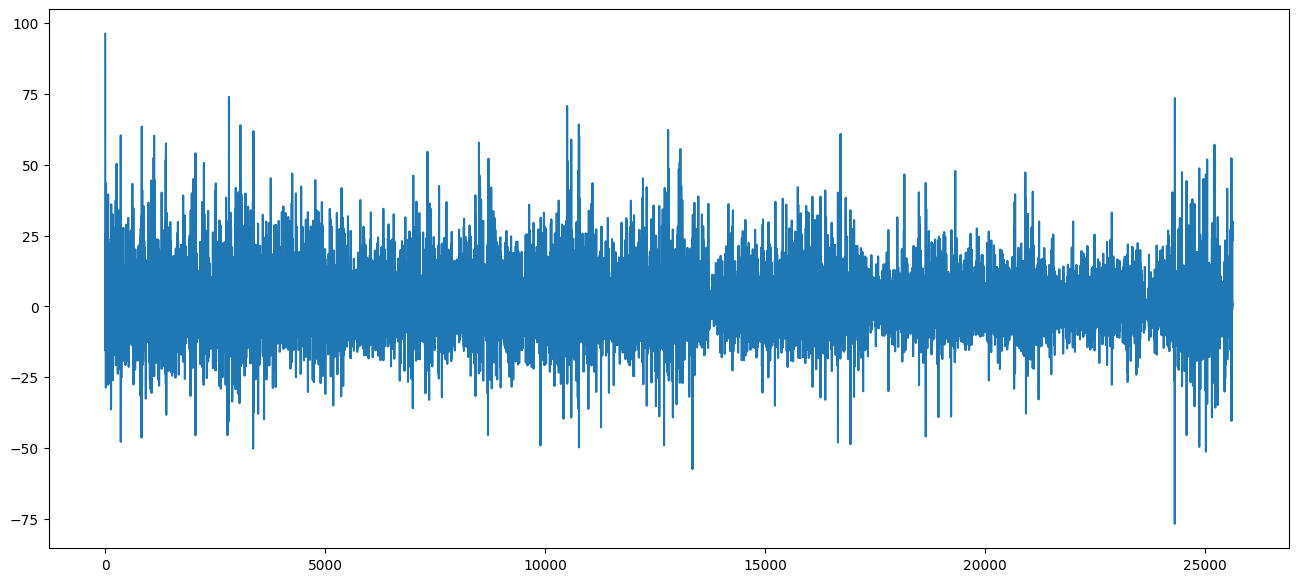

In [29]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])
series.diff().fillna(series).plot(figsize=(16, 7))

## Lets run some correlation tests

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

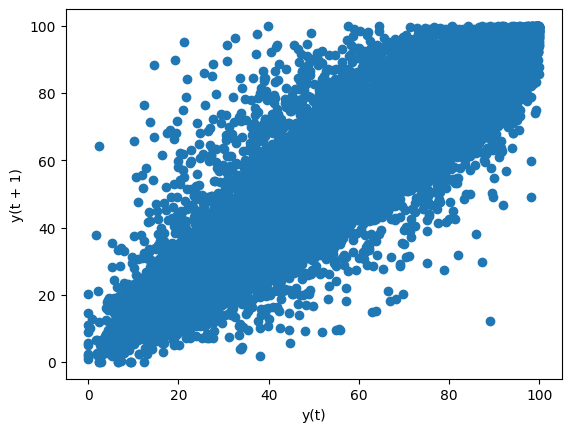

In [30]:
pd.plotting.lag_plot(series)

We can clearly see that there is some correlation in the data. Lets find the Pearson correlation coefficient.

In [31]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.922919
t+1  0.922919  1.000000


The value 0.922919 tell us, that there is stong positive correlation.

Autocorrelation plot:

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

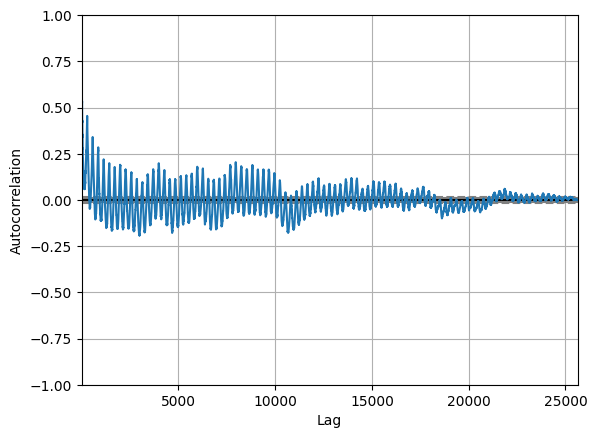

In [32]:
pd.plotting.autocorrelation_plot(series)

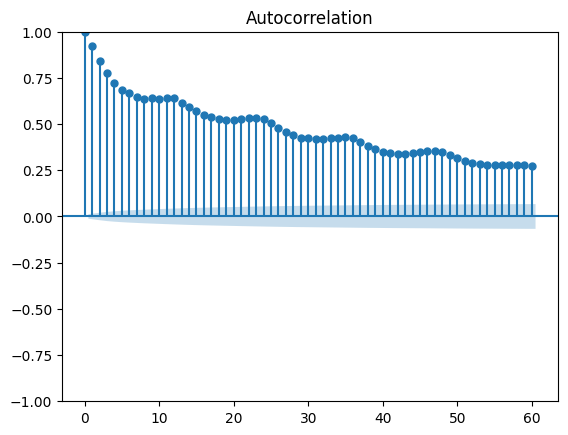

In [33]:
plot_acf(series, lags=60)
plt.show()

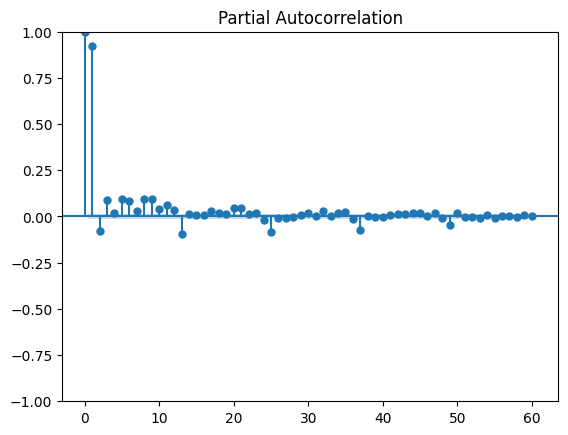

In [34]:
plot_pacf(series, lags=60)
plt.show()

## Ljung-Box Test and Information Criteria

In [50]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
print(len(train))
print(len(test))

20504
5127


In [51]:
def worker_func(id : int):
    if id % 10 == 0:
        print(f"Processing {id} by thread {threading.get_native_id()}")
    model = AutoReg(X, lags=id)
    result = model.fit()
    aic = result.aic
    bic = result.bic
    residuals = result.resid
    result = acorr_ljungbox(residuals, lags=[id])
    p_value = result.iloc[0,1]
    return id, aic, bic, p_value

In [52]:
dir = 'output/information_criteria/'
if len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))]) <= 0:
    for x in range(10, 101):
        result = []
        with concurrent.futures.ThreadPoolExecutor(threading.active_count() - 1) as e:
            fut = [e.submit(worker_func, i) for i in range(x*100 + 1, ((x + 1) * 100) + 1)]
            for r in concurrent.futures.as_completed(fut):
                result.append(r.result())

        result = sorted(result, key=lambda x : x[0])
        import json
        with open(f"{x}.json", 'w') as json_file:
            json.dump(result, json_file)

(array([  54,   56,   57, ..., 1397, 1398, 1399]),)
P Values:  [2.24416276e-29 5.37422316e-37 5.93866467e-02 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
Selected Order (p): 1


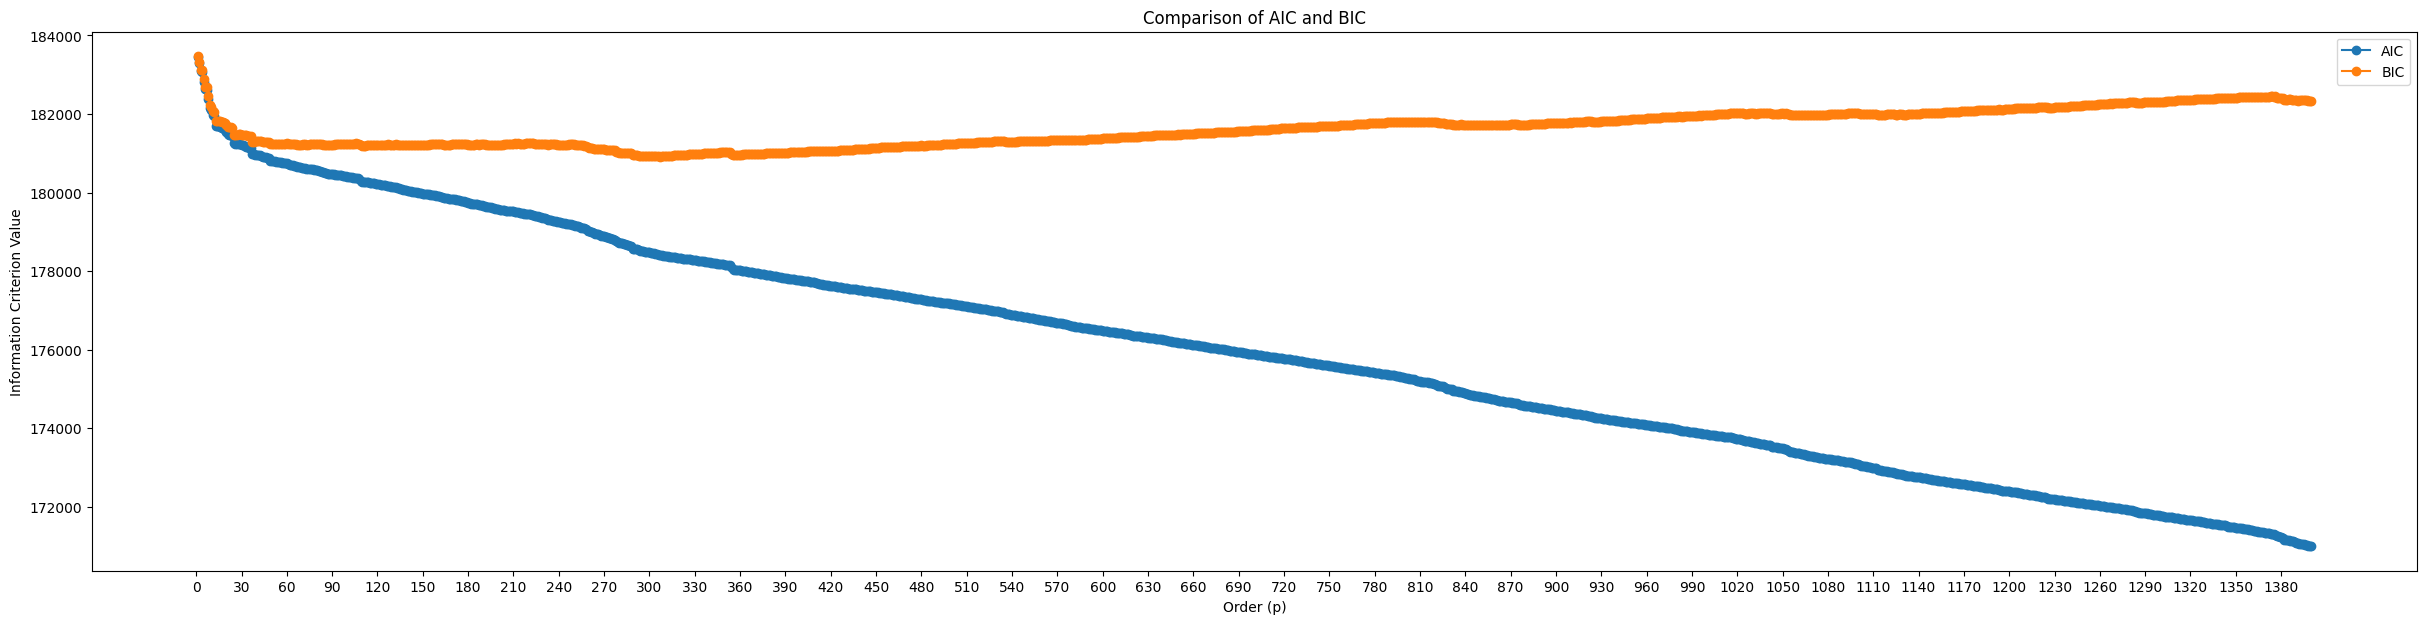

In [64]:
data = []
for file in os.listdir(dir):
    full_file_name = dir + file
    with open(full_file_name, 'r') as json_file:
        new_data = json.load(json_file)
    data.extend([dato for dato in new_data])
data = sorted(data, key=lambda x : x[0])
data = np.array(data)
aic_values = data[:,1]
bic_values = data[:,2]
p_values = data[:,3]

threshold = 0.05
selected_order = np.argmax(np.array(p_values) < threshold) + 1
print(np.where(p_values == 1))
print("P Values: ", p_values)
print("Selected Order (p):", selected_order)

plt.figure(figsize=(30,7))
plt.plot(range(1, len(data) + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, len(data) + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.xticks(np.arange(0, len(data), 30.0))
plt.legend()
plt.show()

Coefficients: [ 1.99453933  0.94284416 -0.15817653 ...  0.01972429 -0.01099367
  0.00635243]
predicted=70.427828, expected=69.151800
predicted=55.130089, expected=15.442400
predicted=65.624378, expected=80.195500
predicted=56.087693, expected=80.383800
predicted=63.845159, expected=34.015600
predicted=58.092625, expected=7.725280
Test RMSE: 25.964


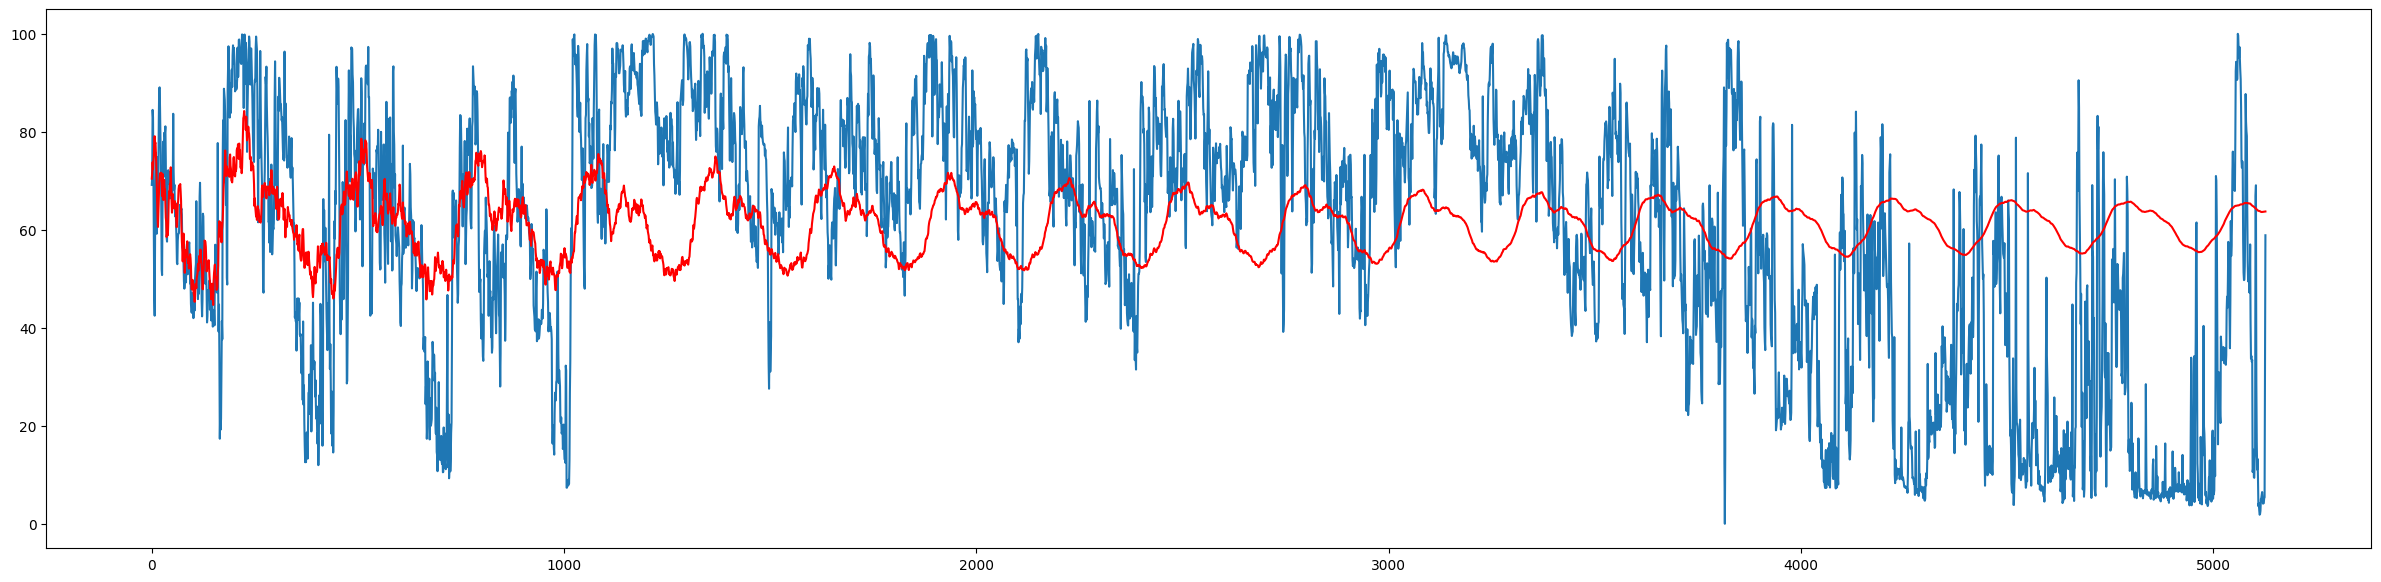

In [67]:
# train autoregression
LAGS = 1400
model = AutoReg(train, lags=LAGS)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    if i % 1000 == 0:
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.figure(figsize=(30,7))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [61]:
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                20504
Model:                  AutoReg(1200)   Log Likelihood              -67501.315
Method:               Conditional MLE   S.D. of innovations              7.987
Date:                Mon, 27 Nov 2023   AIC                         137406.630
Time:                        21:42:13   BIC                         146864.048
Sample:                          1200   HQIC                        140506.117
                                20504                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0585      0.603      3.413      0.001       0.876       3.241
y.L1           0.9412      0.007    130.775      0.000       0.927       0.955
y.L2          -0.1575      0.010    -15.936      0.0

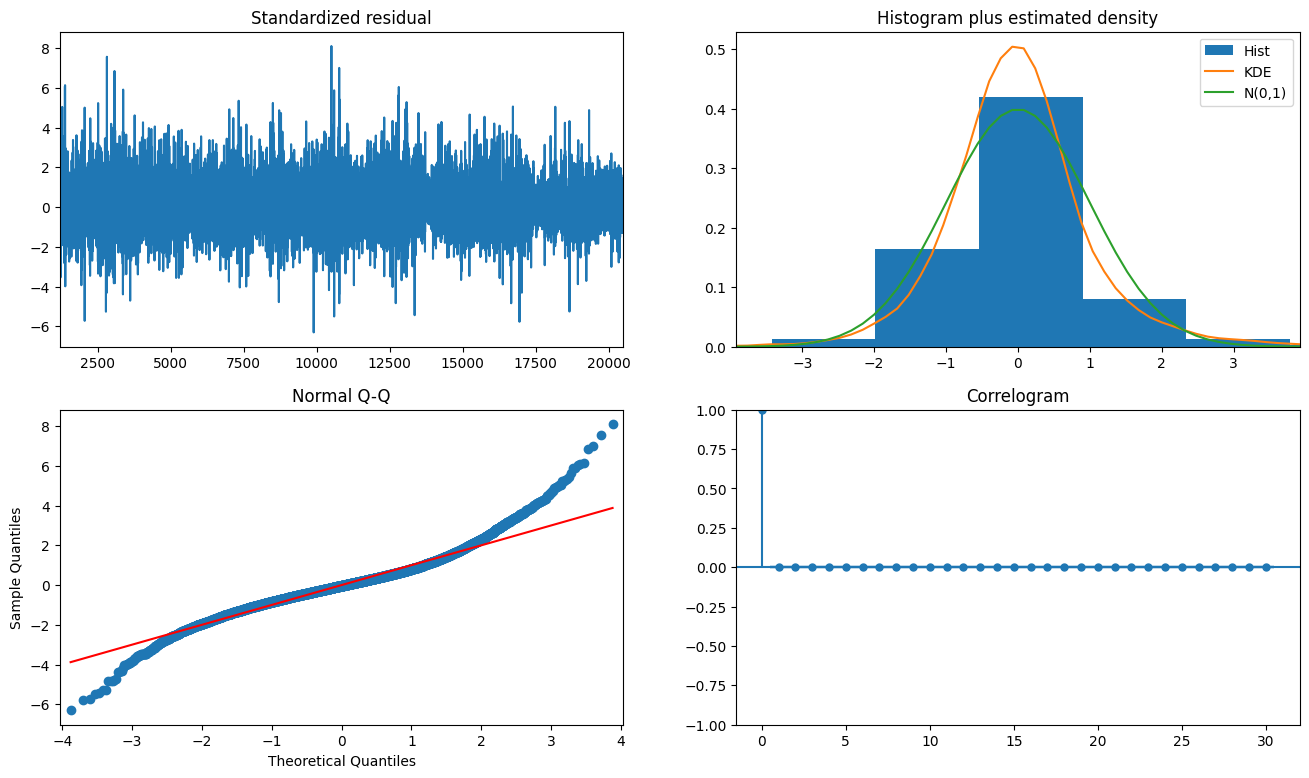

In [62]:

fig = plt.figure(figsize=(16, 9))
fig = model_fit.plot_diagnostics(lags=30, fig=fig)